In [2]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25850 sha256=552e52596ce88e5bee1f06dd8176927301142d5f1f0f621fb5551f4dc9a455c6
  Stored in directory: /Users/alexei/Library/Caches/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install opencv-python

     |████████████████████████████████| 52.4MB 9.9MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense, Input 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import EfficientNetB4, MobileNetV2#, ResNet50, Xception
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse

import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

from imutils import paths
import cv2

import pickle

In [2]:
print(tf.__version__)

2.3.1


In [44]:
model_type='mobilenetv2'

first_time_training=True

PROJECT_PATH = os.getcwd()
print('PROJECT_PATH: ', PROJECT_PATH)

ACCURACY_LOSS_OUPUT_FILE = os.path.join(PROJECT_PATH , 'log/'+model_type+'/'+model_type+'.jpg')
print('ACCURACY_LOSS_OUPUT_FILE: ', ACCURACY_LOSS_OUPUT_FILE)

TARGET_CLASSIFICATION_MODEL = os.path.join(PROJECT_PATH , 'trained_models/'+model_type+'/'+model_type+'.h5')
print('TARGET_CLASSIFICATION_MODEL: ', TARGET_CLASSIFICATION_MODEL)

CHECKPOINT_PATH = os.path.join(PROJECT_PATH , 'checkpoints/'+model_type+'/'+model_type+'.h5')
print('CHECKPOINT_PATH: ', CHECKPOINT_PATH)

LOGFILE_PATH = os.path.join(PROJECT_PATH , 'log/'+model_type+'/'+model_type+'.csv')
print('LOGFILE_PATH: ', LOGFILE_PATH)

PROJECT_PATH:  /Users/alexei/marmitoph_transfer_learning
ACCURACY_LOSS_OUPUT_FILE:  /Users/alexei/marmitoph_transfer_learning/log/mobilenetv2/mobilenetv2.jpg
TARGET_CLASSIFICATION_MODEL:  /Users/alexei/marmitoph_transfer_learning/trained_models/mobilenetv2/mobilenetv2.h5
CHECKPOINT_PATH:  /Users/alexei/marmitoph_transfer_learning/checkpoints/mobilenetv2/mobilenetv2.h5
LOGFILE_PATH:  /Users/alexei/marmitoph_transfer_learning/log/mobilenetv2/mobilenetv2.csv


In [4]:
sys.path.append(PROJECT_PATH)
import computer_vision_lib  
from computer_vision_lib import *

# **Load the Dataset**

In [5]:
data_dir = 'datasets/data'
filename = os.path.join(os.getcwd(), data_dir, "input_data.csv")

df = pd.read_csv(filename)
df['photo'] = df['photo'].apply(lambda x: os.path.join( data_dir, x))
df['photo'] = df['photo'].str.replace(r'\'', '_')
df['label'] = df['label'].str.replace(r'\'', '_')

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_validation_test_split(df, df_validation_size= 0.01, df_test_size = 0.01):
  # Split Test vs (Train/Validation) sets
  y = df['label']
  stratified_split = StratifiedShuffleSplit(n_splits=2, test_size =df_test_size)
  for train_index, test_index in stratified_split.split(df, y):
      df_train_val, df_test = df.iloc[train_index].copy(), df.iloc[test_index].copy()
      
  # Split Train vs Validation sets
  y_train_val = df_train_val['label']

  stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=df_validation_size/(1-df_test_size))
  for train_index, test_index in stratified_split.split(df_train_val, y_train_val):
      df_train, df_validation = df_train_val.iloc[train_index].copy(), df_train_val.iloc[test_index].copy()

  return df_train, df_validation, df_test

In [7]:
df_train, df_validation, df_test = train_validation_test_split(df, df_validation_size= 0.1, df_test_size = 0.1)
    
print(f"Length of the train set : {len(df_train)}")
print(f"Length of the validation set : {len(df_validation)}")
print(f"Length of the test set : {len(df_test)}")

Length of the train set : 800
Length of the validation set : 100
Length of the test set : 100


In [8]:
IMAGE_SIZE = 224

def create_input_tensor(df, size):
  x = np.zeros((len(df), size, size, 3))
  for i, ind in enumerate(df.index):
    im = cv2.imread(df['photo'].loc[ind])
    x[i] = tf.image.resize(im, (size, size))
  x /= 255
  return x

x_train = create_input_tensor(df_train, IMAGE_SIZE)
x_validation = create_input_tensor(df_validation, IMAGE_SIZE)
x_test = create_input_tensor(df_test, IMAGE_SIZE)

In [9]:
IMAGE_SIZE=x_train.shape[1]
print(IMAGE_SIZE)

224


In [10]:
labels = df['label'].unique()
# Number of classes
NUM_CLASSES = len(labels)
print(NUM_CLASSES)

dict_num_to_label = {i:lab for i, lab in enumerate(labels)}
dict_label_to_num = {lab:i for i, lab in enumerate(labels)}

10


In [42]:
with open('dict_num_to_label.pickle', 'wb') as handle:
    pickle.dump(dict_num_to_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
def get_encoded_target(df, dict_label_to_num):
  NUM_CLASSES = len(dict_label_to_num.keys())
  y = df['label'].apply(lambda x: dict_label_to_num[x])
  y = tf.keras.utils.to_categorical(y, NUM_CLASSES)
  return y

y_train = get_encoded_target(df_train, dict_label_to_num)
y_validation = get_encoded_target(df_validation, dict_label_to_num)
y_test = get_encoded_target(df_test, dict_label_to_num)

In [12]:
print("Taille de y_train : {}".format(y_train.shape))
print("Taille de y_validation : {}".format(y_validation.shape))
print("Taille de y_test : {}".format(y_test.shape))

Taille de y_train : (800, 10)
Taille de y_validation : (100, 10)
Taille de y_test : (100, 10)


# **Dataset Visualization**

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


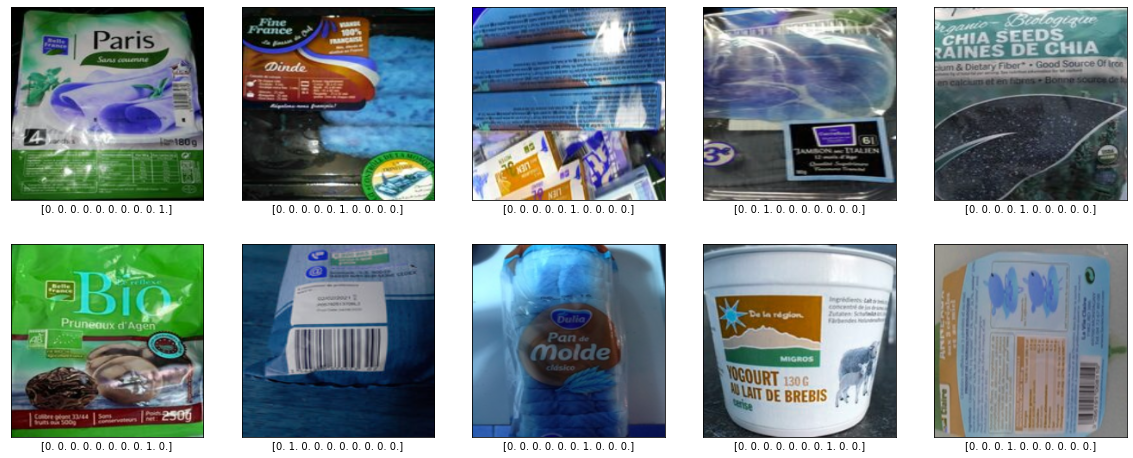

In [13]:
computer_vision_lib.plot_sample_from_dataset(x_train, y_train,rows=2, colums=5, width=20,height=8)


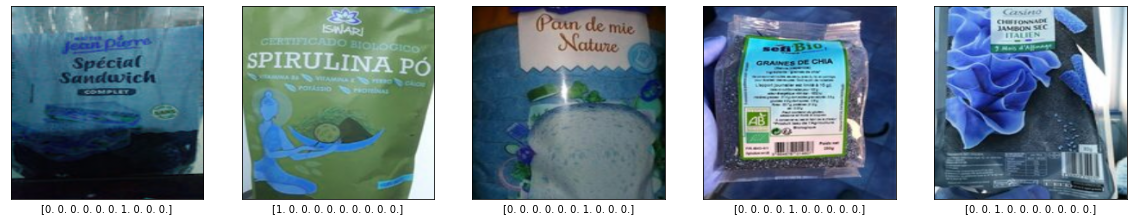

In [14]:
computer_vision_lib.plot_sample_from_dataset(x_validation, y_validation,rows=1, colums=5, width=20,height=8)

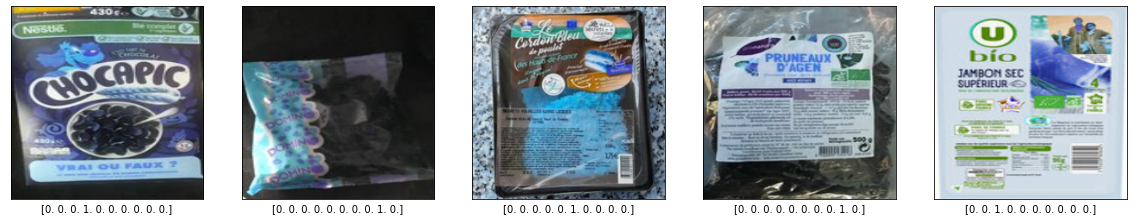

In [15]:
computer_vision_lib.plot_sample_from_dataset(x_test, y_test,rows=1, colums=5, width=20,height=8)


# Training Configuration

# Data Augmentation

In [16]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=20)
	#fill_mode="nearest")
	#brightness_range=[0.2,1.0])
	#horizontal_flip=True)

In [30]:
effnet = EfficientNetB4(
    weights="imagenet",
    include_top=False, 
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)   
)

mobnet = MobileNetV2(
    weights="imagenet", 
    include_top=False, 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE,3),
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))
)

baseModel = mobnet

In [31]:
model = Sequential()

model.add(baseModel)

model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten(name="flatten"))
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [32]:
for layer in baseModel.layers:
    layer.trainable = True

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               163968    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [33]:
#import tf.keras.callbacks.Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle

cp1 = ModelCheckpoint(
    filepath=CHECKPOINT_PATH, 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1, 
    mode='auto'
)

csv_logger = CSVLogger(LOGFILE_PATH, append=True)

callbacks_list = [cp1, csv_logger]

In [22]:
if (first_time_training==False):
    model = tf.keras.models.load_model(TARGET_CLASSIFICATION_MODEL)

In [34]:
#SET THE HYPERPARAMETERS OF THE TRAINING

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
INITIAL_EPOCH = 0
NB_EPOCHS = 100
EPOCHS = INITIAL_EPOCH + NB_EPOCHS
BS = 64


# compile our model
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

[INFO] compiling model...


In [35]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
    optimizer=opt, 
    metrics=["accuracy"]
)

In [36]:
#create folder if they do not exists
LOG_PATH = PROJECT_PATH+'log/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
LOG_PATH=PROJECT_PATH+'checkpoints/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

In [37]:
history = model.fit(
    trainAug.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    validation_data=(x_validation, y_validation),
    validation_steps=len(x_validation) // BS,
    epochs=EPOCHS, 
    callbacks=callbacks_list, 
    initial_epoch=INITIAL_EPOCH
)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 2.3110 - accuracy: 0.0951
Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /Users/alexei/marmitoph_transfer_learning/checkpoints/mobilenetv2/mobilenetv2.h5
12/12 [==============================] - 89s 7s/step - loss: 2.3110 - accuracy: 0.0951 - val_loss: 2.2985 - val_accuracy: 0.1000
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 2.2724 - accuracy: 0.1712
Epoch 00002: val_accuracy did not improve from 0.10000
12/12 [==============================] - 66s 5s/step - loss: 2.2724 - accuracy: 0.1712 - val_loss: 2.2922 - val_accuracy: 0.0900
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 2.2397 - accuracy: 0.2161
Epoch 00003: val_accuracy improved from 0.10000 to 0.17000, saving model to /Users/alexei/marmitoph_transfer_learning/checkpoints/mobilenetv2/mobilenetv2.h5
12/12 [==============================] - 61s 5s/step - loss: 2.2397 - accuracy: 0.2161 - va

Epoch 53/100
12/12 [==============================] - ETA: 0s - loss: 1.5421 - accuracy: 0.9959
Epoch 00053: val_accuracy improved from 0.52000 to 0.54000, saving model to /Users/alexei/marmitoph_transfer_learning/checkpoints/mobilenetv2/mobilenetv2.h5
12/12 [==============================] - 60s 5s/step - loss: 1.5421 - accuracy: 0.9959 - val_loss: 1.9949 - val_accuracy: 0.5400
Epoch 54/100
12/12 [==============================] - ETA: 0s - loss: 1.5363 - accuracy: 0.9932
Epoch 00054: val_accuracy did not improve from 0.54000
12/12 [==============================] - 60s 5s/step - loss: 1.5363 - accuracy: 0.9932 - val_loss: 1.9897 - val_accuracy: 0.5200
Epoch 55/100
12/12 [==============================] - ETA: 0s - loss: 1.5357 - accuracy: 0.9986
Epoch 00055: val_accuracy did not improve from 0.54000
12/12 [==============================] - 60s 5s/step - loss: 1.5357 - accuracy: 0.9986 - val_loss: 1.9910 - val_accuracy: 0.5100
Epoch 56/100
12/12 [==============================] - ETA:

Epoch 82/100
12/12 [==============================] - ETA: 0s - loss: 1.5074 - accuracy: 0.9986
Epoch 00082: val_accuracy did not improve from 0.54000
12/12 [==============================] - 61s 5s/step - loss: 1.5074 - accuracy: 0.9986 - val_loss: 1.9613 - val_accuracy: 0.5200
Epoch 83/100
12/12 [==============================] - ETA: 0s - loss: 1.5086 - accuracy: 0.9959
Epoch 00083: val_accuracy did not improve from 0.54000
12/12 [==============================] - 59s 5s/step - loss: 1.5086 - accuracy: 0.9959 - val_loss: 1.9607 - val_accuracy: 0.5100
Epoch 84/100
12/12 [==============================] - ETA: 0s - loss: 1.5038 - accuracy: 0.9973
Epoch 00084: val_accuracy did not improve from 0.54000
12/12 [==============================] - 60s 5s/step - loss: 1.5038 - accuracy: 0.9973 - val_loss: 1.9651 - val_accuracy: 0.5000
Epoch 85/100
12/12 [==============================] - ETA: 0s - loss: 1.5057 - accuracy: 0.9946
Epoch 00085: val_accuracy did not improve from 0.54000
12/12 [==

In [38]:
LOG_PATH = PROJECT_PATH + 'trained_models/' + model_type + '/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
model.save(TARGET_CLASSIFICATION_MODEL)

# See Results

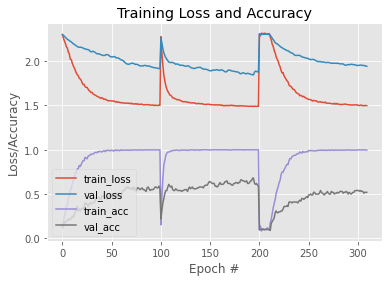

In [39]:
computer_vision_lib.plot_loss_accuracy_from_csv(LOGFILE_PATH)